In [1]:
#System and performance tool
import os

#Data Management
import pandas as pd
import numpy as np

#Visualization tool
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine Learning tool
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/yogisharo/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/yogisharo/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


Import Data

In [3]:
# path to data
RAW_DATA_FOLDER = '/Users/yogisharo/Documents/Kaggle/predict_future_sales_kaggle/data/'

In [4]:
#Load Data
import pandas as pd
items               =pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'items.csv'))
item_categories     =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'item_categories.csv'))
shops               =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'shops.csv'))
train_df            =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'sales_train.csv'))
test_df             =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'test.csv'))

In [5]:
print('items: ' + str(items.shape))
print()
items.info(null_counts=True)
print()
print('-'*50)
print('item_categories :' + str(item_categories.shape))
print()
item_categories.info(null_counts=True)
print()
print('-'*50)
print('shops :' + str(shops.shape))
print()
shops.info(null_counts=True)

items: (22170, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB

--------------------------------------------------
item_categories :(84, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB

--------------------------------------------------
shops :(60, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):

In [7]:
print('train_df :' + str(train_df.shape) )
print()
train_df.info(null_counts=True)
print('-'*50)
print()
print('test_df :' + str(test_df.shape))
print()
test_df.info(null_counts=True)
print('-'*50)

print('Proportion of unique item in train set : ' + str(train_df.item_id.nunique()) + ' / ' + str(items.item_id.nunique()))
print('Proportion of unique item in test set : ' + str(test_df.item_id.nunique()) + ' / ' + str(items.item_id.nunique()))
print()
print('Proportion of unique shops in train set : ' + str(train_df.shop_id.nunique()) + ' / ' + str(shops.shop_id.nunique()))
print('Proportion of unique shops in test set : ' + str(test_df.shop_id.nunique()) + ' / ' + str(shops.shop_id.nunique()))



train_df :(2935849, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
--------------------------------------------------

test_df :(214200, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
-----------------

Data Overview

In [8]:
print('Train_data Minimum Date: ' + train_df['date'].min())
print('Train_data Maximum Date: ' + train_df['date'].max())

Train_data Minimum Date: 01.01.2013
Train_data Maximum Date: 31.12.2014


# 1. Data Cleaning

<AxesSubplot:xlabel='item_price'>

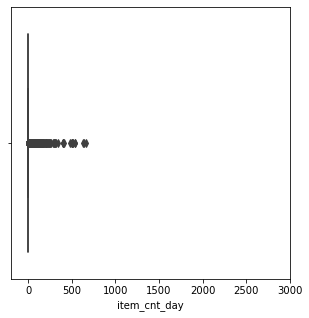

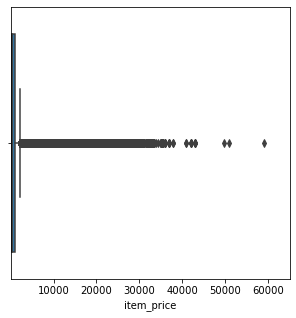

In [25]:
plt.figure(figsize=(5,5))
plt.xlim(-200, 3000)
flierprops = dict(marker='o', markerfacecolor='blue', markersize=5,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train_df.item_cnt_day)

plt.figure(figsize=(5,5))
plt.xlim(-200, 30000)
plt.xlim(train_df.item_price.min(), train_df.item_price.max()*1.1)
sns.boxplot(x=train_df.item_price)

In [10]:
#Remove outlier based on boxplot
print('Data set size before remove outlier:', train_df.shape)
train_df = train_df[(train_df.item_price < 300000 )& (train_df.item_cnt_day < 1000)]
print('Data set size before remove outlier:', train_df.shape)

Data set size before remove outlier: (2935849, 6)
Data set size before remove outlier: (2935846, 6)


count    2.935846e+06
mean     1.241562e+00
std      2.217636e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.690000e+02
Name: item_cnt_day, dtype: float64

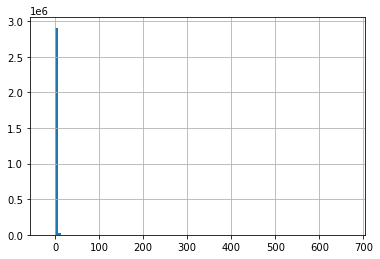

In [11]:
#Display distribution of  item count day
train_df.item_cnt_day.hist(bins=100)
train_df.item_cnt_day.describe()

In [12]:
#Item price should at least 1
print('Data set size before remove item price 0 cleaning:', train_df.shape)
train_df = train_df.query('item_price > 0')
print('Data set size after remove item price 0 cleaning:', train_df.shape)

Data set size before remove item price 0 cleaning: (2935846, 6)
Data set size after remove item price 0 cleaning: (2935845, 6)


In [21]:
#Display items count of day with negative numbers
train_df[train_df['item_cnt_day'] < 0].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0


In [22]:
#Only get non-negative count of day value
print('Data set size before remove item price 0 cleaning:', train_df.shape)
train_df = train_df.query('item_cnt_day >= 0')
print('Data set size after remove item price 0 cleaning:', train_df.shape)

Data set size before remove item price 0 cleaning: (2935845, 6)
Data set size after remove item price 0 cleaning: (2928489, 6)
